# Figure 1a: MWR atmospheric correction

Figure 1a-d illustrate key steps in the NaRRS snow depth and SIT processing chain and are combined with a flow chart to create Figure 1 in the manuscript. 

Here we will demonstrate the along-tack atmospheric correction applied to the S3 MWR observations for a single example date, creating Figure 1a that shows this correction for the 23.8 GHz channel on 2020-12-15. As decribed in the manuscript, the atmopsheric correction has been computed using the RTTOV radiative transfer model.

**Data required**

Either

* Sentinel-3 L2 Sea Ice Thematic data
* Sentinel-3 L2 Sea Ice Thematic metadata file located at NaRRS/Data/sentinel3_sral_products_20160921_20230430.parquet
* Atmospherically corrected S3 products
* NSIDC EASE2 NH 6.25 km resolution sea ice region mask (for coastal buffering)

Or,

* The precompiled example date (2020-12-15) Tb correction dataset located at NaRRS/Data/sentinel3_nh_atmos_tb_correction_example_20201215.nc. In which case, steps 2-4 can be commented out.



1) Import required packages

In [1]:
import sys
sys.path.append('/home/cn/NaRRS')
import pandas as pd
import xarray as xr
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec

2) Define functions to find and process relevant files

In [2]:

def get_sentinel3_product_dataframe_in_interval(start_datetime, end_datetime, hemisphere, lat_limit=None, enhanced_measurements=True):
    
    """
    Get a dataframe of Sentinel-3 L2 Sea Ice Thematic products within a specified time interval, hemisphere, and optional latitude limit. 
    This function assumes the 'sentinel3_sral_products_20160921_20230430.parquet' is available in the '../Misc/' directory.
    This parquet file should contain metadata about the Sentinel-3 L2 Sea Ice Thematic products, including, for each product:
    - 'product_path': Path to the product file.
    - 'satellite': Satellite identifier (e.g., 'S3A' or 'S3B').
    - 'name': Name of the product.
    - 'sensing_start': Start datetime of sensing.
    - 'sensing_end': End datetime of sensing.
    - 'cycle': Orbit cycle number.
    - 'enhanced_exists': Boolean indicating if enhanced measurements are available. 
    - 'min_lat': Minimum latitude covered by the product.
    - 'max_lat': Maximum latitude covered by the product.

    Parameters:
    start_datetime (Timestamp): Start of the time interval.
    end_datetime (Timestamp): End of the time interval.
    hemisphere (str): 'nh' for Northern Hemisphere or 'sh' for Southern Hemisphere.
    lat_limit (float, optional): Latitude limit for filtering products. Defaults to None.
    enhanced_measurements (bool, optional): If True, only include products with enhanced measurements available (rarely, there is no enhanced_measurement.nc processed by ESA). Defaults to True.
    
    Returns:
    DataFrame: Filtered dataframe of Sentinel-3 products.
    
    """
    
    all_files_df = pd.read_parquet('../Data/sentinel3_sral_products_20160921_20230430.parquet')
    if enhanced_measurements:
        all_files_df = all_files_df[all_files_df['enhanced_exists'] == True]
    
    if lat_limit is not None:
        if hemisphere == 'nh':
            all_files_df = all_files_df[all_files_df['max_lat'] >= lat_limit]
        elif hemisphere == 'sh':
            all_files_df = all_files_df[all_files_df['min_lat'] <= lat_limit]
        else:
            raise ValueError('Hemisphere must be either "nh" or "sh"')

    all_files_df = all_files_df[(all_files_df['sensing_end'] >= start_datetime) & (all_files_df['sensing_start'] < end_datetime)]
    return all_files_df


def process_s3_file(s3_dirpath, hemisphere, tb_corr_iteration=1):
    
    """
    Process a Sentinel-3 L2 Sea Ice Thematic product to extract and filter relevant data, interpolate auxiliary data to the along-track coordinates, and merge with corrected brightness temperatures.
    
    Parameters:
    s3_dirpath (str): Path to the Sentinel-3 product directory.
    hemisphere (str): 'nh' for Northern Hemisphere or 'sh' for Southern Hemisphere.
    tb_corr_iteration (int): Iteration number for the brightness temperature correction. Defaults to 1. This corresponds to the Tb corrections as described in the manuscript.
    
    Returns:
    xarray.Dataset: Processed and filtered Sentinel-3 dataset with corrected brightness temperatures.
    """
    from tools.common_functions import get_S3_data_ds, interpolate_auxiliary_data_to_track, get_tb_corrected_fpath, filter_sentinel3_dataset
    
    print(f"Processing {s3_dirpath}")

    #specify the variables to load from the Sentinel-3 dataset
    hz_1_names = ['time_01', 'lat_01', 'lon_01', 'tb_238_01', 'tb_238_quality_flag_01', 'tb_238_std_01', 'tb_365_01', 'tb_365_quality_flag_01', 'tb_365_std_01']
   
    #set the appropriate EASE-2 projection EPSG code
    if hemisphere == 'nh':
        ease2_epsg = 6931
    elif hemisphere == 'sh':
        ease2_epsg = 6932

    #load the Sentinel-3 data
    s3_ds = get_S3_data_ds(s3_dirpath, vars_01=hz_1_names, vars_20_ku=None, decode_times=True, coord_transform_epsg=ease2_epsg)
    
    #load the s3 data again with decode_times=False to get the raw time values
    s3_ds_raw_times = get_S3_data_ds(s3_dirpath, vars_01=['time_01'], vars_20_ku=None, decode_times=False)
    
    #add the raw time values to the main dataset
    s3_ds['time_01_raw'] = (('time_01'), s3_ds_raw_times['time_01'].values)
    s3_ds['time_01_raw'].attrs = s3_ds_raw_times['time_01'].attrs

    #interpolate auxiliary data to the Sentinel-3 track
    s3_ds = interpolate_auxiliary_data_to_track(s3_ds, hemisphere, measurement_frequency=['01'], distance_to_ice_edge=False, sea_ice_concentration=False)

    #Get the sentinel-3 corrected brightness temperatures
    era5_source = 'gcp' #here we are specifying that the ERA5 data used in the Tb corrections came from Google Cloud Platform (https://console.cloud.google.com/storage/browser/gcp-public-data-arco-era5)
    corrected_tb_fpath = get_tb_corrected_fpath(s3_dirpath.split('/')[-1], hemisphere, era5_source, iteration=tb_corr_iteration)
    corrected_tb_ds = xr.open_dataset(corrected_tb_fpath)

    #merge the corrected brightness temperatures with the Sentinel-3 data
    #conflicts have been noted to arise because of extra decimal places in the original brightness temperature vars
    #therefore, we will override conflicts
    s3_ds = xr.merge([s3_ds, corrected_tb_ds], join='inner', compat='override')
    
    # define some filters for the Sentinel-3 data
    lat_limit = 40 if hemisphere == 'nh' else -40
    lat_range = [90, lat_limit] if hemisphere == 'nh' else [lat_limit, -90]
    min_dist_coast = 25e3

    #filter the Sentinel-3 data
    s3_ds = filter_sentinel3_dataset(s3_ds, measurement_frequency = ['01'], lat_range=lat_range, min_dist_coast=min_dist_coast, drop=True)

    if s3_ds.time_01.size == 0:
        print(f"No valid data found in {s3_dirpath} after filtering. Skipping file.")
        return None
    
    s3_ds = s3_ds[['corr_tb_238_01', 'corr_tb_365_01', 'tb_238_01', 'tb_365_01', 'atmos_corr_365_01', 'atmos_corr_238_01', 'dist_to_coast_01']]
    
    return s3_ds

3) Find the NH Sentinel-3 L2 Sea Ice Thematic product files for the example date 

In [3]:
#set the hemisphere
hemisphere = 'nh'
#set the minimum latitude for filtering
min_lat = 55

#set the example date start and ends times
start_date = pd.to_datetime('2020-12-15')
end_date = pd.to_datetime('2020-12-16') - pd.Timedelta(microseconds=1)

#search for relevant sentinel-3 files in the datetime interval
files_df = get_sentinel3_product_dataframe_in_interval(start_date, end_date, hemisphere, lat_limit=min_lat, enhanced_measurements=True)
s3_files = files_df['product_path'].tolist()
print(f"Total number of files found for {start_date.date()}: {len(s3_files)}")

Total number of files found for 2020-12-15: 29


4) Load the Tb corrections for each track on our example date, combining them as a single dataset saved to the data directory

In [4]:
#load the sentinel-3 data - using parallel processing to speed things up
njobs=8
s3_tb_corr_ds = Parallel(n_jobs=njobs)(delayed(process_s3_file)(s3_dirpath, hemisphere) for s3_dirpath in s3_files)
#remove any None values from the list
s3_tb_corr_ds = [ds for ds in s3_tb_corr_ds if ds is not None]
#concatenate the data along the time dimension
s3_tb_corr_ds = xr.concat(s3_tb_corr_ds, dim='time_01')

s3_tb_corr_ds.attrs = {
    'description': 'Sentinel-3 L2 Sea Ice Thematic Product MWR brightness temperatures on December 15, 2020, including atmospheric corrections via the RTTOV RTM.'}

#make sure each variable/coordinate is a float64
for var in s3_tb_corr_ds.data_vars:
    if s3_tb_corr_ds[var].dtype != 'float64':
        s3_tb_corr_ds[var] = s3_tb_corr_ds[var].astype('float64')
for coord in s3_tb_corr_ds.coords:
    if s3_tb_corr_ds[coord].dtype != 'float64':
        s3_tb_corr_ds[coord] = s3_tb_corr_ds[coord].astype('float64')
        
#add compression encoding to reduce file size
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in s3_tb_corr_ds.data_vars}  
 
#save the dataset
s3_tb_corr_ds.to_netcdf(f'/home/cn/NaRRS/Data/sentinel3_{hemisphere}_atmos_tb_correction_example_{start_date.strftime("%Y%m%d")}.nc')

Processing /cpnet/li2_cpdata/SATS/RA/S3B/L2/THEMATIC/BC005/SI/047/S3B_SR_2_LAN_SI_20201214T235635_20201215T001727_20230510T135929_1252_047_002______LN3_R_NT_005.SEN3Processing /cpnet/li2_cpdata/SATS/RA/S3A/L2/THEMATIC/BC005/SI/066/S3A_SR_2_LAN_SI_20201215T054228_20201215T055103_20230703T061658_0515_066_148______LN3_R_NT_005.SEN3

Processing /cpnet/li2_cpdata/SATS/RA/S3A/L2/THEMATIC/BC005/SI/066/S3A_SR_2_LAN_SI_20201215T040101_20201215T041057_20230703T061102_0595_066_147______LN3_R_NT_005.SEN3
Processing /cpnet/li2_cpdata/SATS/RA/S3A/L2/THEMATIC/BC005/SI/066/S3A_SR_2_LAN_SI_20201215T021629_20201215T023044_20230703T065828_0855_066_146______LN3_R_NT_005.SEN3Processing /cpnet/li2_cpdata/SATS/RA/S3B/L2/THEMATIC/BC005/SI/047/S3B_SR_2_LAN_SI_20201215T050319_20201215T051133_20230510T133026_0493_047_005______LN3_R_NT_005.SEN3
Processing /cpnet/li2_cpdata/SATS/RA/S3A/L2/THEMATIC/BC005/SI/066/S3A_SR_2_LAN_SI_20201215T003159_20201215T005843_20230703T072550_1603_066_145______LN3_R_NT_005.SEN3
Proce

/tmp/ipykernel_2962208/3769273294.py:25: SerializationWarning: saving variable lat_01 with floating point data as an integer dtype without any _FillValue to use for NaNs
  s3_tb_corr_ds.to_netcdf(f'/home/cn/NaRRS/Data/sentinel3_{hemisphere}_atmos_tb_correction_example_{start_date.strftime("%Y%m%d")}.nc')
/tmp/ipykernel_2962208/3769273294.py:25: SerializationWarning: saving variable lon_01 with floating point data as an integer dtype without any _FillValue to use for NaNs
  s3_tb_corr_ds.to_netcdf(f'/home/cn/NaRRS/Data/sentinel3_{hemisphere}_atmos_tb_correction_example_{start_date.strftime("%Y%m%d")}.nc')


5) Load the complied atmospheric Tb correction dataset 

In [5]:
#load the atmospheric correction example ds
s3_tb_corr_ds = xr.open_dataset(f'../Data/sentinel3_{hemisphere}_atmos_tb_correction_example_{start_date.strftime("%Y%m%d")}.nc')

6) Plot the atmopsheric Tb correction for each channel

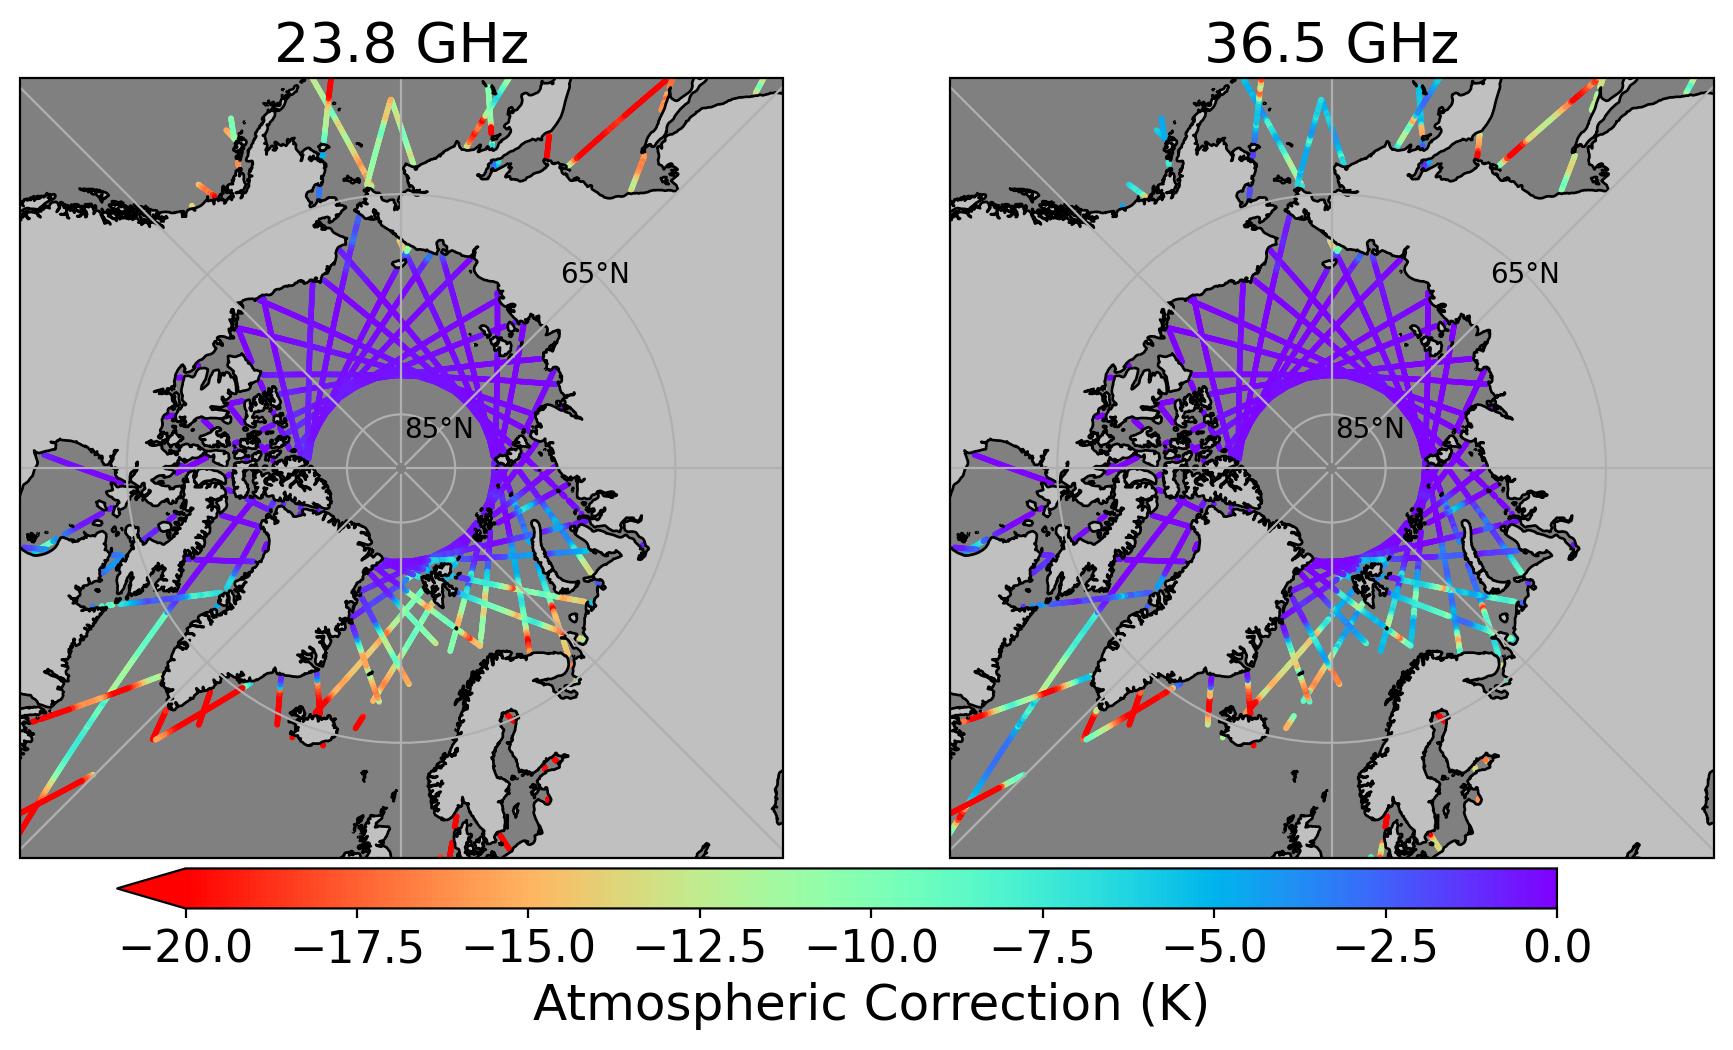

In [7]:
#Along-track atmospheric correction
fig = plt.figure(figsize=(12, 5), dpi=200)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.001, bottom=0.1)
vmin = -20
vmax = 0

#tb_238_01 correction
ax1 = fig.add_subplot(gs[0], projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
ax1.add_feature(cfeature.OCEAN, color='gray')
ax1.add_feature(cfeature.LAND, color='silver', edgecolor='black')
ax1.add_feature(cfeature.COASTLINE)
ax1.gridlines(draw_labels=True, dms=False, x_inline=True, y_inline=True, xlocs=[-135, -90, -45, 0, 45, 90, 135, 180], ylocs=[65, 85])
sc1 = ax1.scatter(s3_tb_corr_ds['lon_01'], s3_tb_corr_ds['lat_01'], c=s3_tb_corr_ds['atmos_corr_238_01'], cmap='rainbow_r', transform=ccrs.PlateCarree(), s=1, vmin=vmin, vmax=vmax)
ax1.set_title('23.8 GHz', fontsize=20)

#tb_365_01 correction
ax2 = fig.add_subplot(gs[1], projection=ccrs.NorthPolarStereo())
ax2.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
ax2.add_feature(cfeature.OCEAN, color='gray')
ax2.add_feature(cfeature.LAND, color='silver', edgecolor='black')
ax2.add_feature(cfeature.COASTLINE)
ax2.gridlines(draw_labels=True, dms=False, x_inline=True, y_inline=True, xlocs=[-135, -90, -45, 0, 45, 90, 135, 180], ylocs=[65, 85])
sc2 = ax2.scatter(s3_tb_corr_ds['lon_01'], s3_tb_corr_ds['lat_01'], c=s3_tb_corr_ds['atmos_corr_365_01'], cmap='rainbow_r', transform=ccrs.PlateCarree(), s=1, vmin=vmin, vmax=vmax)
ax2.set_title('36.5 GHz', fontsize=20)

#colorbar
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.04]) 
cbar = plt.colorbar(sc2, cax=cbar_ax, orientation='horizontal', extend='min')
cbar.set_label('Atmospheric Correction (K)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.show()

7) Plot the atmopsheric Tb correction for the 23.8 GHz channel only (Figure 1a)

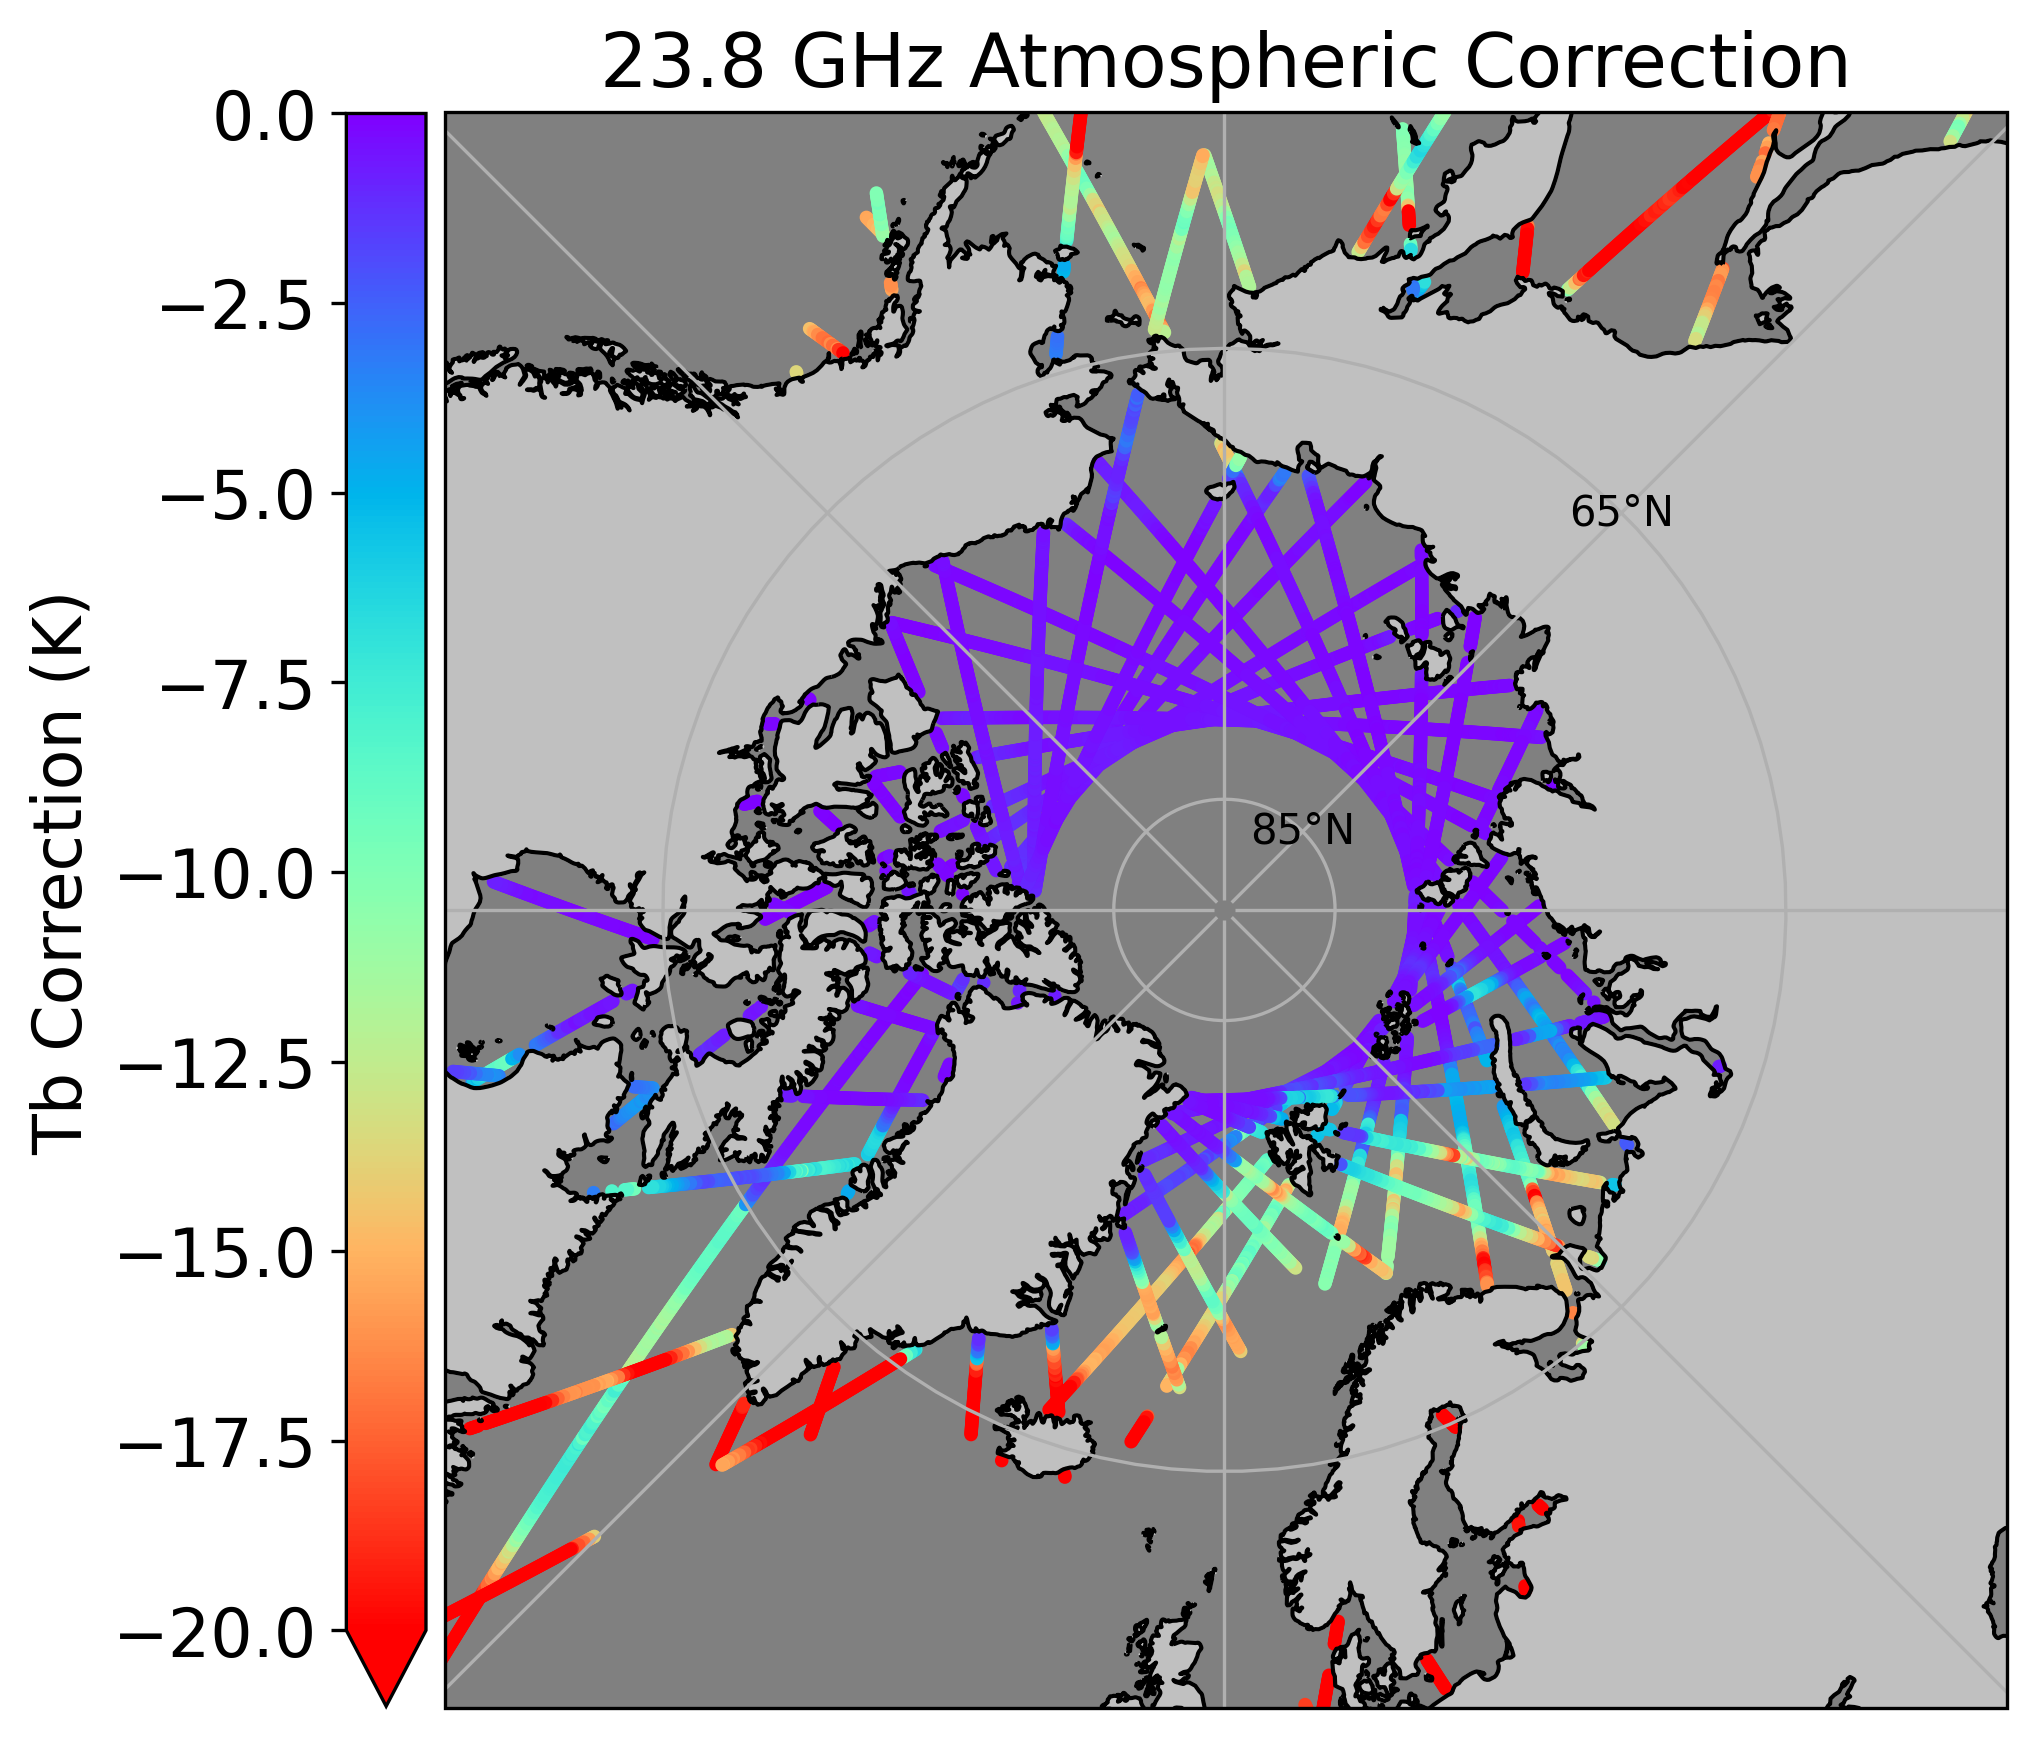

In [8]:
# Along-track atmospheric correction for 23.8 GHz channel
fig = plt.figure(figsize=(8, 7), dpi=300)
vmin = -20
vmax = 0

#tb_238_01 correction
ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, color='gray')
ax.add_feature(cfeature.LAND, color='silver', edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True, dms=False, x_inline=True, y_inline=True, xlocs=[-135, -90, -45, 0, 45, 90, 135, 180], ylocs=[65, 85])
sc = ax.scatter(s3_tb_corr_ds['lon_01'], s3_tb_corr_ds['lat_01'], c=s3_tb_corr_ds['atmos_corr_238_01'], cmap='rainbow_r', transform=ccrs.PlateCarree(), s=5, vmin=vmin, vmax=vmax)
ax.set_title('23.8 GHz Atmospheric Correction', fontsize=18)

#colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', extend='min', location='left', pad=0.01, shrink=0.985)
cbar.set_label('Tb Correction (K)', fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.savefig('S3_23_8_GHz_atmospheric_correction_example.png', dpi=300, bbox_inches='tight')
plt.show()